In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import datetime
import os

import xgboost as xgb
from sklearn.model_selection import train_test_split
import lightgbm
import warnings
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')
#한글 깨짐방지
plt.rc('font',family = 'Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

C:\Users\User\Anaconda3\lib\site-packages\distributed\config.py:63: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config.update(yaml.load(text) or {})


In [1]:
path = './data/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
submission  = pd.read_csv(path + 'submission.csv')
merge_df = pd.concat([train,test])

In [2]:
train.shape, test.shape

((3362796, 8), (473392, 8))

### Data setting
* 거래 취소의 경우 거래금액, 환불금액 2회 체크되므로 거래취소 횟수 만큼 제외
* 날짜기준으로 묶어줄 필요가 있음
* 주말과 요일은 날짜기준으로 결합

-> 시간은 EDA에서 상세히 다시살펴볼것 (새벽시간대 매출이 높은 곳이라던지)

### 필요없는 row 제거
* 2nd 솔루션 : 거래기록이 160일 이하인 경우/ 2018-07-31 주변 5일 내 거래가 없으면 제외, 
    * test의 경우 2019-03-31 이전 7일간 거래가 없으면 폐업으로 추정
* 변경 : 거래기록 100일 이하인경우 삭제, 거래횟수가 30회 이하면 제외

In [4]:
# train 중 전체 거래일이 100일 이하인경우 학습에 사용불가
train['date'] = pd.to_datetime(train['date'])
gap_check = train.groupby('store_id')['date'].agg(['min','max'])
gap = (gap_check['max']-gap_check['min']).apply(lambda x : x.days)
gap.name = 'gap'
row_count = train.groupby('store_id')['date'].count()
gap = pd.concat([gap,row_count],axis=1)

del_id = gap.loc[(gap['gap']<130)|(gap['date']<29)].index
clean_train = train[~(train.store_id.isin(del_id))]

In [5]:
print(f'기본 트레인 길이 : {train.shape[0]}, 기본트레인 상점수 : {train.store_id.nunique()}')
print(f'clean 트레인 길이 : {clean_train.shape[0]}, clean 트레인 상점수 : {clean_train.store_id.nunique()}')
print(f'길이 차이 : {train.shape[0] - clean_train.shape[0]},상점수 차이 : {train.store_id.nunique() - clean_train.store_id.nunique()}')

기본 트레인 길이 : 3362796, 기본트레인 상점수 : 1775
clean 트레인 길이 : 3322858, clean 트레인 상점수 : 1425
길이 차이 : 39938,상점수 차이 : 350


In [6]:
#전체날짜의 휴일 요일
all_dates = merge_df.drop_duplicates('date').sort_values('date')
all_dates = all_dates[['date','days_of_week','holyday']]
all_dates.reset_index(drop=True, inplace=True)
all_dates['date'] = pd.to_datetime(all_dates['date'])

In [7]:
#환불금액이 동일하지 않은 경우도 있음 
train.loc[(train.store_id == 176)&(train.date == datetime.datetime(2018,7,13))]

,store_id,date,time,card_id,amount,installments,days_of_week,holyday
486173,176,2018-07-13,13:34:02,edba13c668,-2700,18.0,4,0
486174,176,2018-07-13,16:30:12,77fff27956,2750,NaN,4,0


In [13]:
def reform_data(df, isTrain = True):
    '''날짜별로 나열되어있는 데이터를 상정별로 병합
    
    데이터를 store_id를 기준으로 병합. 최종 거래일로 부터 100일인 날짜를 마지막으로 설정 후
    최초 거래일자부터의 데이터를 결합. 마지막 100일의 거래금액은 y로 변환
    
    all_dates는 train,test의 날짜를 결합해놓은 데이터 
    
    추가되는 feature
    amount_mean, amount_mid : 전체 거래금액 평균 및 중앙값
    count_sum, count_mean : 전체 거래횟수 및 평균 거래횟수
    daily_trans_amount : 일별 평균 거래금액
    mean_gap : 다음날짜까지의 거래기간의 평균
    0~6_sum, 0~6_mean : 요일별 전체 거래금액 및 평균 거래금액
    unholy, holy_mean, sum : 평일/주말 평균 거래 금액 및 전체 거래금액
    7D,15D,30D_sum, median, mean : 마지막 날짜에서 7,15,30일간 거래금액
    7,15,30D_MA7_mean : 마지막 날짜에서 7,15,30일간 7일간 이동평균
    7,15,30D_MA15_mean : 마지막 날짜에서 7,15,30일간 15일간 이동평균
    7,15,30D_MA30_mean : 마지막 날짜에서 7,15,30일간 30일간 이동평균
    
    Parameters
    ---------
    df(DataFrame) : train, test 데이터 입력
    isTrain(bool) : train일때 True, test일때, False
    
    '''
    df.loc[df.amount <0,'refund'] = 1
    sample_df = df.groupby(['date','store_id']).agg({'amount':['sum','count'],'refund':['sum']}).reset_index()
    sample_df.columns = ['date','store_id','amount_sum','amount_count','refund_sum']
    sample_df['date'] = pd.to_datetime(sample_df['date'])
    sample_df['temp_date'] = sample_df['date']

    #거래횟수당 평균 거래금액 
    sample_df['trans_amount'] = sample_df['amount_sum']/(sample_df['amount_count']-sample_df['refund_sum'])
    sample_df['trans_amount'].fillna(0,inplace= True)

    #날짜병합
    sample_df = pd.merge(sample_df,all_dates)

    sample_df.set_index("date",inplace=True)

    store_id_list = sample_df.store_id.unique()
    fin_ls =[]
    add_row = pd.DataFrame({'holyday_amount_sum':0,'holyday_amount_mean':0},index = ['holy']) #holyday 없는경우 
    
    for store_id in notebook.tqdm(store_id_list):

        store = sample_df[sample_df.store_id == store_id]    
        store = store.asfreq('D',fill_value = 0) #일자별로 열추가 
        store['temp_date'] = store.index
        store['store_id'] = store_id

        # 7일, 15일, 30일간의 이동평균 계산 
        store['MA7'] = store['amount_sum'].rolling('7D').mean()
        store['MA15'] = store['amount_sum'].rolling('15D').mean()
        store['MA30'] = store['amount_sum'].rolling('30D').mean()

        # train set인 경우 마지막 100일은 y값으로 저장되어야함
        # store_x는 100일전까지 기간 데이터 
        if isTrain:
            store_y = store.last("100D")
            y = store_y.amount_sum.sum()
            store_x = store[store.temp_date < store_y.iloc[0].temp_date]
        #test는 전체
        else : 
            y = 0
            store_x = store[:]

        feat = dict()

        #amount >0 이상인 경우만 
        over_zero = store_x.loc[store_x.amount_sum>0]
        
        # base (거래가 있는 경우만 )
        feat['store_id'] = store_id
        feat['y'] = y
        feat['amount_mean'] = over_zero.amount_sum.mean()  # 거래액의 평균
        feat['amount_mid'] = over_zero.amount_sum.median() # 거래액의 중간값
        feat['count_sum'] = over_zero.amount_count.sum() # 전체 거래 횟수
        feat['count_mean'] = over_zero.amount_count.mean() # 평균 거래 횟수
        feat['refund_count'] = over_zero.refund_sum.sum() # 전체 최소 횟수
        feat['refund_rate'] = over_zero['refund_sum'].sum()/over_zero.shape[0] # 취소율
        feat['daily_trans_amount'] = over_zero.trans_amount.sum() / over_zero.shape[0] #일자별 평균 금액의 평균

        feat['mean_gap'] = (over_zero.index[1:] - over_zero.index[:-1]).days.values.mean() # 거래일자간 평균 기간
        
        #weekly (거래가 있는 경우만 고려)
        weekly = over_zero[['days_of_week','amount_sum']].groupby('days_of_week').agg(['sum','mean'])
        weekly.columns = ['weekly_amount_sum','weekly_amount_mean']

        weekly_sum = weekly['weekly_amount_sum']
        weekly_sum.index = [f"{index}_sum" for index in weekly['weekly_amount_sum'].index.values]
        feat.update(weekly_sum.to_dict())

        weekly_mean = weekly['weekly_amount_mean']
        weekly_mean.index = [f"{index}_mean" for index in weekly['weekly_amount_mean'].index.values]
        feat.update(weekly_mean.to_dict())

        #holyday (거래가 있는 경우만 고려)
        holyday = over_zero[['holyday','amount_sum']].groupby('holyday').agg(['sum','mean'])
        holyday.columns = ['holyday_amount_sum','holyday_amount_mean']

        try : 
            holyday.index = ['unholy','holy']
        except :
            holyday = pd.concat([holyday,add_row])
            
        holyday_sum = holyday['holyday_amount_sum']
        holyday_sum.index = [f"{index}_sum" for index in holyday['holyday_amount_sum'].index.values]
        feat.update(holyday_sum.to_dict())

        holyday_mean = holyday['holyday_amount_mean']
        holyday_mean.index = [f"{index}_mean" for index in holyday['holyday_amount_mean'].index.values]
        feat.update(holyday_mean.to_dict())
    
        #이동평균값 
        feat['7D_mean'] = store_x.last('7D').amount_sum.mean()
        feat['15D_mean'] = store_x.last('15D').amount_sum.mean()
        feat['30D_mean'] = store_x.last('30D').amount_sum.mean()

        feat['7D_median'] = store_x.last('7D').amount_sum.median()
        feat['15D_median'] = store_x.last('15D').amount_sum.median()
        feat['30D_median'] = store_x.last('30D').amount_sum.median()

        feat['7D_sum'] = store_x.last('7D').amount_sum.sum()
        feat['15D_sum'] = store_x.last('15D').amount_sum.sum()
        feat['30D_sum'] = store_x.last('30D').amount_sum.sum()

        feat['7D_MA7_mean'] = store_x.last('7D').MA7.mean()
        feat['15D_MA7_mean'] = store_x.last('15D').MA7.mean()
        feat['30D_MA7_mean'] = store_x.last('30D').MA7.mean()

        feat['7D_MA15_mean'] = store_x.last('7D').MA15.mean()
        feat['15D_MA15_mean'] = store_x.last('15D').MA15.mean()
        feat['30D_MA15_mean'] = store_x.last('30D').MA15.mean()

        feat['7D_MA30_mean'] = store_x.last('7D').MA30.mean()
        feat['15D_MA30_mean'] = store_x.last('15D').MA30.mean()
        feat['30D_MA30_mean'] = store_x.last('30D').MA30.mean()

        fin_ls.append(feat)
        
    fin_df = pd.DataFrame(fin_ls)
    return fin_df

In [14]:
reform_train = reform_data(clean_train)
reform_test = reform_data(test,isTrain=False)

C:\Users\User\AppData\Roaming\Python\Python36\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [31]:
#전체횟수가 40회 이하인경우 제외
reform_train = reform_train[~(reform_train['count_sum']<40)]

In [32]:
reform_train.shape,reform_test.shape

((1327, 46), (200, 46))

In [27]:
reform_train.describe()

,store_id,y,amount_mean,amount_mid,count_sum,count_mean,daily_trans_amount,mean_gap,0_sum,1_sum,...,30D_sum,7D_MA7_mean,15D_MA7_mean,30D_MA7_mean,7D_MA15_mean,15D_MA15_mean,30D_MA15_mean,7D_MA30_mean,15D_MA30_mean,30D_MA30_mean
count,1472.000000,1.472000e+03,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1469.000000,1.463000e+03,1.441000e+03,...,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000
mean,898.811821,5.966662e+04,1100.034203,856.925951,1814.253397,5.252746,471.817911,3.119983,4.350701e+04,3.829044e+04,...,18685.821332,628.630181,623.284832,630.641859,623.016760,629.408382,629.083111,630.382238,629.187836,626.982452
std,520.840882,1.124273e+05,1831.179828,1500.514687,3631.139977,8.443075,1021.579326,4.450737,8.443196e+04,7.285542e+04,...,35404.926113,1213.714479,1189.063556,1181.166574,1189.037457,1189.712681,1166.159492,1182.366269,1169.593187,1145.356770
min,0.000000,7.500000e+01,42.333333,25.000000,1.000000,1.000000,14.107333,1.000000,8.300000e+01,8.100000e+01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,442.750000,1.543550e+04,348.487033,249.875000,139.000000,1.505895,104.083761,1.093617,6.882000e+03,5.580000e+03,...,4313.250000,121.403061,133.516667,148.559524,134.264286,145.796667,151.186111,148.113095,151.186111,149.833333
50%,902.500000,3.407050e+04,628.369832,463.000000,534.000000,2.598669,187.844873,1.351974,1.749800e+04,1.807800e+04,...,10187.000000,333.928571,342.666667,344.178571,342.666667,348.102222,350.161458,344.178571,349.773333,351.850000
75%,1350.250000,6.821975e+04,1242.175027,950.000000,1894.000000,5.506673,404.262300,2.833333,4.794800e+04,4.415400e+04,...,21267.000000,742.571429,735.514286,729.564286,733.714286,743.400000,724.777778,724.483333,729.095556,717.035278
max,1799.000000,2.755612e+06,27187.379310,24630.000000,56334.000000,114.967347,21159.659091,50.200000,1.374296e+06,1.406489e+06,...,879408.000000,29783.020408,29715.542857,29794.490476,29715.542857,29672.248889,29489.235556,29794.490476,29489.235556,28786.225556


In [37]:
del_col = ['0_sum','1_sum','2_sum','3_sum','4_sum','5_sum','6_sum',
          '0_mean','1_mean','2_mean','3_mean','4_mean','5_mean','6_mean']

In [42]:
#train
reform_train['week_sum'] = reform_train[['0_sum','1_sum','2_sum','3_sum','4_sum']].sum(axis=1)
reform_train['weekend_sum'] = reform_train[['5_sum','6_sum']].sum(axis=1)

reform_train['week_mean'] = reform_train[['0_mean','1_mean','2_mean','3_mean','4_mean']].mean(axis=1)
reform_train['weekend_mean'] = reform_train[['5_mean','6_mean']].mean(axis=1)

#test
reform_test['week_sum'] = reform_test[['0_sum','1_sum','2_sum','3_sum','4_sum']].sum(axis=1)
reform_test['weekend_sum'] = reform_test[['5_sum','6_sum']].sum(axis=1)

reform_test['week_mean'] = reform_test[['0_mean','1_mean','2_mean','3_mean','4_mean']].mean(axis=1)
reform_test['weekend_mean'] = reform_test[['5_mean','6_mean']].mean(axis=1)

In [43]:
reform_train.drop(del_col,axis= 1,inplace = True)
reform_test.drop(del_col,axis= 1,inplace = True)

In [79]:
money_col = ['amount_mean', 'amount_mid', '0_sum', '1_sum', '2_sum', '3_sum', '4_sum', '5_sum', '6_sum', '0_mean',
             '1_mean', '2_mean', '3_mean', '4_mean', '5_mean', '6_mean',
             'unholy_sum', 'holy_sum', 'unholy_mean', 'holy_mean', '7D_mean',
             '15D_mean', '30D_mean', '7D_median', '15D_median', '30D_median',
             '7D_sum', '15D_sum', '30D_sum', '7D_MA7_mean', '15D_MA15_mean',
             '30D_MA30_mean', '7D_MA7_median', '15D_MA15_median', '30D_MA30_median',
             '7D_MA7_sum', '15D_MA15_sum', '30D_MA30_sum']

In [84]:
reform_train = reform_train[['y', 'amount_mean', 'count_sum', 'count_mean',
       'refund_count', 'refund_rate', 'mean_gap',
       'holy_sum', 'holy_mean', '7D_mean',
       '7D_MA7_mean', 'weekend_mean']]

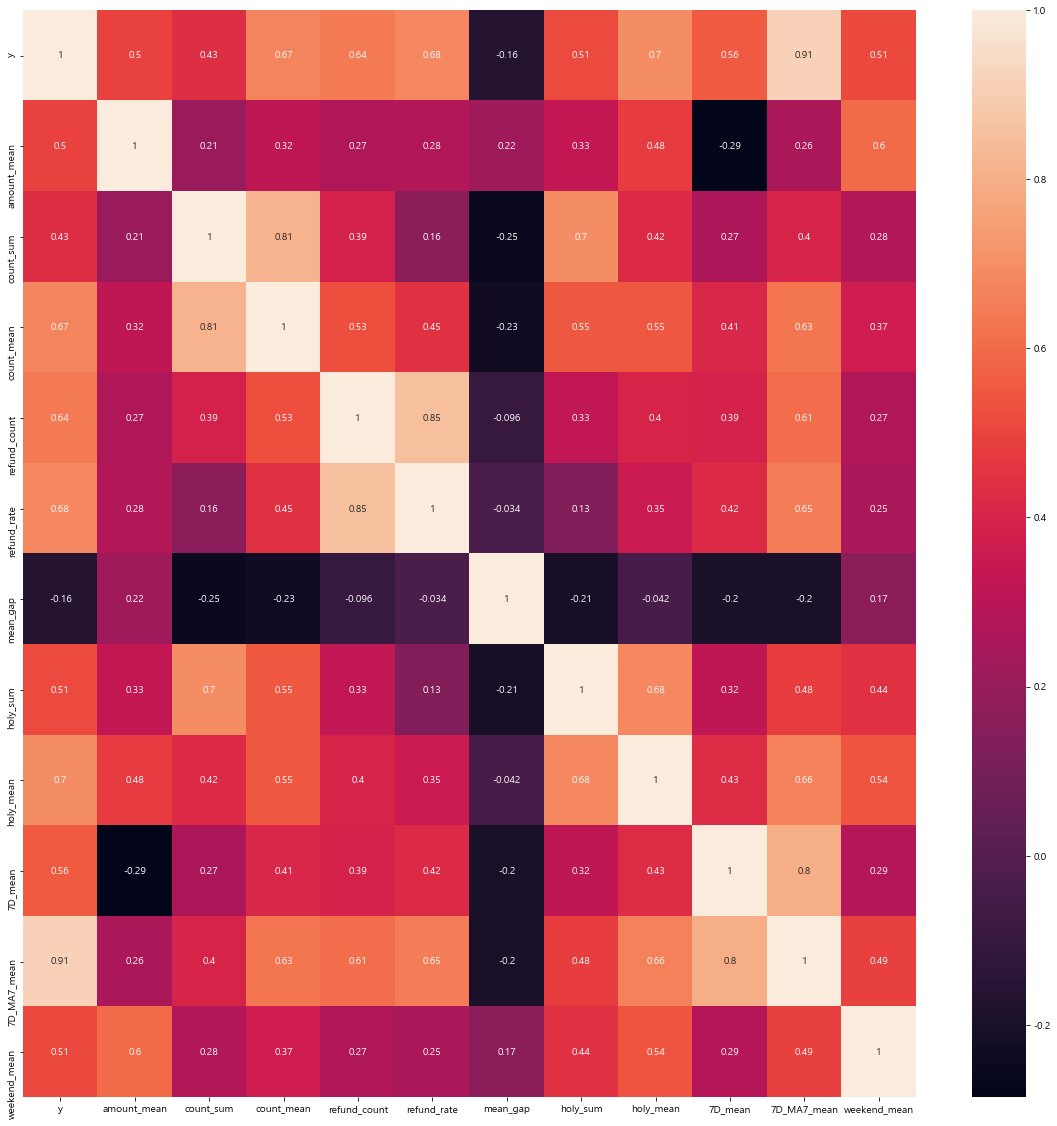

In [85]:
plt.figure(figsize = (20,20))
sns.heatmap(reform_train.corr(),annot=True)

### modeling
* 2nd 솔루션은 xgb, train_test_split 0.1만

In [86]:
col = [i for i in reform_train.columns if i not in ['store_id','y']]
y = reform_train['y'].values

train_X, test_X, train_y, test_y = train_test_split(reform_train[col],y, test_size=0.3, random_state=4024)

#### lgbm

In [93]:
lgbm = lightgbm.LGBMRegressor(learning_rate=0.001, n_estimators=30000,random_state=42, min_child_samples = 40, 
                              num_leaves=200,)

lgbm.fit(train_X,train_y,eval_set=[(train_X,train_y),(test_X,test_y)], eval_names=['train','test'],eval_metric='rmse',verbose=100, early_stopping_rounds= 500)

Training until validation scores don't improve for 500 rounds
[100]	train's rmse: 124235	train's l2: 1.54343e+10	test's rmse: 77294.9	test's l2: 5.97449e+09
[200]	train's rmse: 119976	train's l2: 1.43943e+10	test's rmse: 72074.5	test's l2: 5.19473e+09
[300]	train's rmse: 116340	train's l2: 1.35349e+10	test's rmse: 67642.6	test's l2: 4.57552e+09
[400]	train's rmse: 113248	train's l2: 1.28251e+10	test's rmse: 63907.8	test's l2: 4.08421e+09
[500]	train's rmse: 110607	train's l2: 1.22339e+10	test's rmse: 60779.8	test's l2: 3.69418e+09
[600]	train's rmse: 108325	train's l2: 1.17343e+10	test's rmse: 58206.8	test's l2: 3.38803e+09
[700]	train's rmse: 106356	train's l2: 1.13115e+10	test's rmse: 56024.1	test's l2: 3.1387e+09
[800]	train's rmse: 104653	train's l2: 1.09523e+10	test's rmse: 54212.3	test's l2: 2.93898e+09
[900]	train's rmse: 103166	train's l2: 1.06432e+10	test's rmse: 52632.5	test's l2: 2.77018e+09
[1000]	train's rmse: 101839	train's l2: 1.03712e+10	test's rmse: 51293.5	test's l2: 

LGBMRegressor(learning_rate=0.001, min_child_samples=40, n_estimators=30000,
              num_leaves=200, random_state=42)

In [88]:
y_pred = lgbm.predict(test_X)
score = np.sqrt(mean_squared_error(test_y, y_pred))
score

46142.225506781186

In [89]:
y_pred = lgbm.predict(reform_test[col])

In [86]:
submission['total_sales'] = y_pred

today = datetime.datetime.today().date()
os.makedirs('./submission/',exist_ok=True)
submission.to_csv(f'./submission/submission_{today}_lgbm_{score}_rmse.csv',index=False)

#### xgb

In [90]:
def XGB_regressor(train_X, train_y, test_X, test_y, metric, feature_name = None, seed_val = 2018, num_rounds = 3000):
    params = {'objective' : 'reg:squarederror',
              'learning_rate' : 0.05,
              'max_depth' : 10,
              'eval_metric': metric,#??? rmse가 아니고??
              'min_child_weight': 1,
              'subsample': 0.7,
              'colsample_bytree' : 0.7,
              'seed': seed_val}
    plst = list(params.items())
    
    xgtrain = xgb.DMatrix(train_X, label = train_y)
    
    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label = test_y)
        watchlist = [ (xgtrain, 'train'), (xgtest, 'test')]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds= 300,verbose_eval= 100)
    else :
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)
        
    return model

In [91]:
model = XGB_regressor(train_X, train_y, test_X, test_y, 'rmse')

[0]	train-rmse:139788.17188	test-rmse:99977.49219
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 300 rounds.
[100]	train-rmse:15516.18652	test-rmse:41203.25000
[200]	train-rmse:3340.87256	test-rmse:43626.78906
[300]	train-rmse:1026.31299	test-rmse:43786.21484
Stopping. Best iteration:
[53]	train-rmse:34994.07031	test-rmse:39064.24219



In [51]:
y_pred = model.predict(xgb.DMatrix(test_X))
score = np.sqrt(mean_squared_error(test_y, y_pred))
score

63738.54722978633

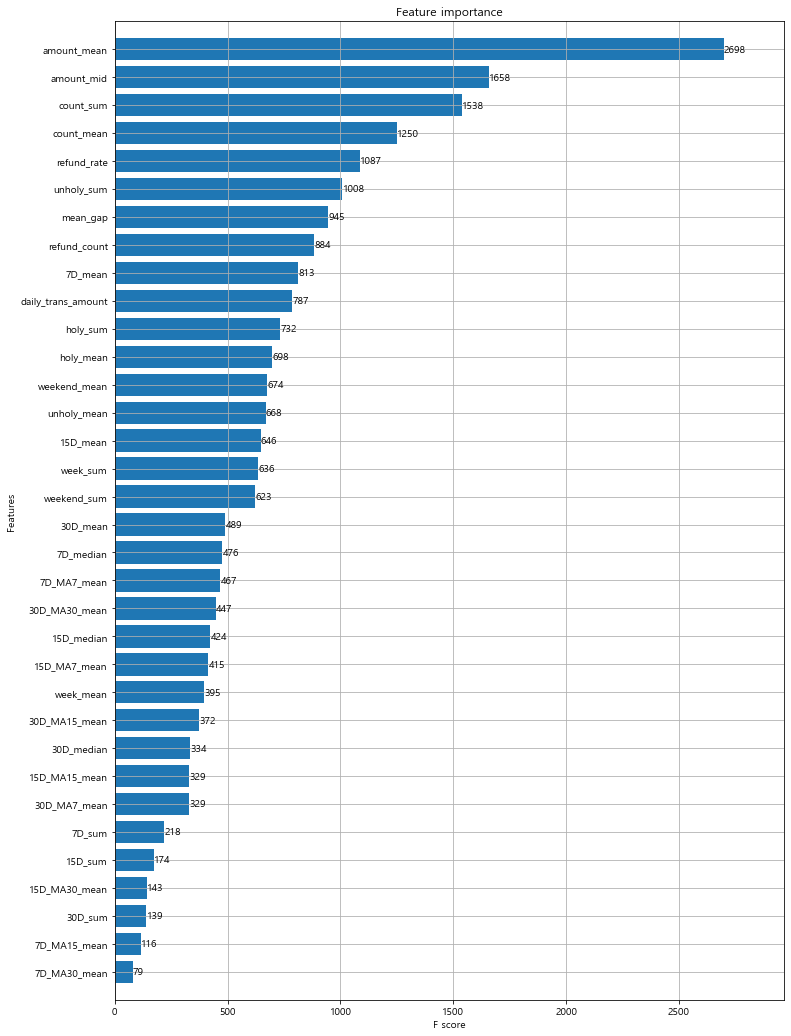

In [52]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [91]:
#몇가지 조정을 더 거친후 제출할 답변임
y_pred = model.predict(xgb.DMatrix(reform_test[col]), ntree_limit = model.best_ntree_limit)

In [92]:
submission['total_sales'] = y_pred

In [93]:
submission['total_sales'] = y_pred

today = datetime.datetime.today().date()
os.makedirs('./submission/',exist_ok=True)
submission.to_csv(f'./submission/submission_{today}_xgb_{score}_rmse.csv',index=False)

### 솔루션에 있는 조정법 적용

In [43]:
test_adj = test.groupby(['date','store_id']).agg({'amount':'sum'}).reset_index()

test_x_store_id = reform_train.iloc[test_X.index]['store_id'].values
train_adj = train[train.store_id.isin(test_x_store_id)].groupby(['date','store_id']).agg({'amount':'sum'}).reset_index()

#### train 선적용
* rmse가 오히려증가

In [44]:
store_id_list = train_adj.store_id.unique()
store_id_list.sort()

feb_march = []
for store_id in store_id_list:
    mini = train_adj[train_adj.store_id == store_id]
    march = mini[mini.date >= datetime.datetime(2018,3,1)]['date'].count()
    feb = mini[mini.date >= datetime.datetime(2018,2,1)]['date'].count() - march 
    feb_march.append((march+feb)/2/31) 

In [53]:
y_pred = model.predict(xgb.DMatrix(test_X))
adj_y_pred= y_pred * feb_march * 0.72
score = np.sqrt(mean_squared_error(test_y, adj_y_pred))
score

54611.801148027844

#### test적용

In [54]:
y_pred = model.predict(xgb.DMatrix(reform_test[col]), ntree_limit = model.best_ntree_limit)

In [59]:
store_id_list = test_adj.store_id.unique()
store_id_list.sort()
test_adj['date'] = pd.to_datetime(test_adj['date'])
feb_march = []
for store_id in store_id_list:
    mini = test_adj[test_adj.store_id == store_id]
    march = mini[mini.date >= datetime.datetime(2018,3,1)]['date'].count()
    feb = mini[mini.date >= datetime.datetime(2018,2,1)]['date'].count() - march 
    feb_march.append((march+feb)/2/31) 

In [60]:
adj_y_pred= y_pred * feb_march * 0.72

In [61]:
submission['total_sales'] = adj_y_pred

today = datetime.datetime.today().date()
os.makedirs('./submission/',exist_ok=True)
submission.to_csv(f'./submission/submission_{today}_xgb_adj_{score}_rmse.csv',index=False)

#### lgbm (log scale)

In [ ]:
reform_train[money_col] = reform_train[money_col].apply(lambda x : np.log(1+x))

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(reform_train[col],y, test_size=0.3, random_state=4024)

In [ ]:
lgbm = lightgbm.LGBMRegressor(learning_rate=0.001, n_estimators=30000)

lgbm.fit(train_X,train_y,eval_set=[(train_X,train_y),(test_X,test_y)], eval_names=['train','test'],eval_metric='rmse',verbose=100, early_stopping_rounds= 500)

In [ ]:
y_pred = lgbm.predict(test_X)
score = np.sqrt(mean_squared_error(test_y, y_pred))

In [ ]:
y_pred = lgbm.predict(reform_test[col])

In [204]:
submission['total_sales'] = y_pred

today = datetime.datetime.today().date()
os.makedirs('./submission/',exist_ok=True)
submission.to_csv(f'./submission/submission_{today}_lgbm_scale_{score}_rmse.csv',index=False)

### 작업본

In [19]:
clean_train.loc[clean_train.amount <0,'refund'] = 1
sample_df = clean_train.groupby(['date','store_id']).agg({'amount':['sum','count'],'refund':'sum'}).reset_index()
sample_df.columns = ['date','store_id','amount_sum','amount_count','refund_sum']
sample_df['date'] = pd.to_datetime(sample_df['date'])
sample_df['temp_date'] = sample_df['date']

#거래횟수당 평균 거래금액 
sample_df['trans_amount'] = sample_df['amount_sum']/(sample_df['amount_count']-sample_df['refund_sum'])
sample_df['trans_amount'].fillna(0,inplace= True)

#날짜병합
sample_df = pd.merge(sample_df,all_dates)

sample_df.set_index("date",inplace=True)

#### 주별, 주말별 계산 어쩌냐

In [55]:
#weekly
weekly_sum = weekly['weekly_amount_sum']
weekly_sum.index = [f"{index}_sum" for index in weekly['weekly_amount_sum'].index.values]
feat.update(weekly_sum.to_dict())

weekly_count = weekly['weekly_amount_count']
weekly_count.index = [f"{index}_count" for index in weekly['weekly_amount_count'].index.values]
feat.update(weekly_count.to_dict())

#holyday
holyday.index = ['unholy','holy']
holyday_sum = holyday['holyday_amount_sum']
holyday_sum.index = [f"{index}_sum" for index in holyday['holyday_amount_sum'].index.values]
feat.update(holyday_sum.to_dict())

holyday_count = holyday['holyday_amount_count']
holyday_count.index = [f"{index}_count" for index in holyday['holyday_amount_count'].index.values]
feat.update(holyday_count.to_dict())

In [228]:
store_x[store_x.amount_sum>0].shape[0]

1

In [54]:
weekly = store[['days_of_week','amount_sum']].groupby('days_of_week').agg(['sum','count'])
weekly.columns = ['weekly_amount_sum','weekly_amount_count']
weekly_dict = weekly.to_dict()

holyday = store[['holyday','amount_sum']].groupby('holyday').agg(['sum','count'])
holyday.columns = ['holyday_amount_sum','holyday_amount_count']
holyday_dict = holyday.to_dict()

In [230]:
store_x

,store_id,amount_sum,amount_count,refund_sum,temp_date,trans_amount,days_of_week,holyday,MA7,MA15,MA30
date,,,,,,,,,,,
2018-04-21,1163,545,1,0.0,2018-04-21,545.0,5,0,545.0,545.0,545.0
2018-04-22,1163,0,0,0.0,2018-04-22,0.0,0,0,272.5,272.5,272.5


In [188]:
store

,store_id,amount_sum,amount_count,refund_sum,temp_date,days_of_week,holyday,trans_amount,MA7,MA15,MA30


In [189]:
store = sample_df[sample_df.store_id == 8]

In [164]:
store = sample_df[sample_df.store_id == store_id]

In [174]:
store.trans_amount.sum()

65714.6097208347

In [173]:
store[store.trans_amount>0].shape[0]

531

In [151]:
store = store.asfreq('D',fill_value = 0)

In [152]:
store['temp_date'] = store.index
store['store_id'] = store_id

In [153]:
store

,store_id,amount_sum,amount_count,refund_sum,temp_date
date,,,,,
2016-08-10,32,140,1,0.0,2016-08-10
2016-08-11,32,0,0,0.0,2016-08-11
2016-08-12,32,0,0,0.0,2016-08-12
2016-08-13,32,60,1,0.0,2016-08-13
2016-08-14,32,0,0,0.0,2016-08-14
...,...,...,...,...,...
2018-07-26,32,884,4,0.0,2018-07-26
2018-07-27,32,549,5,0.0,2018-07-27
2018-07-28,32,709,4,0.0,2018-07-28


In [83]:
store_y = store.last("100D")

In [85]:
store_y.amount_sum.sum()

510